# Machine Learning Algorithm to detect characters written by hand with Keras
Importing the libraries<br>
We import all of the essential libraries first for data loading, processing, model training and performance evaluation

In [74]:
# Basic libraries for data processing and visualisation
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_theme()

# Importing Tensorflow libraries for deep learning algorithms
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad
from keras.optimizers.schedules import ExponentialDecay, InverseTimeDecay
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


# Importing sci-kit learn packages for validation and evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Preprocessing the EMNIST Balanced Dataset for Neural Network Training

In [54]:
# File paths for the EMNIST Balanced dataset
train_path = "EMNIST/emnist-balanced-train.csv"
test_path = "EMNIST/emnist-balanced-test.csv"

# Load the training data and testing data from CSV files into Pandas DataFrames
train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

# Extract feature data (images) and labels (digits) for training and testing sets
x_train = train_df.iloc[:, 1:].values  # All columns except the first column (labels)
x_test = test_df.iloc[:, 1:].values    # All columns except the first column (labels)
y_train = train_df.iloc[:, 0].values   # Only the first column (labels)
y_test = test_df.iloc[:, 0].values     # Only the first column (labels)

# Convert labels to one-hot encoding format for softmax classification in the neural network
one_hot_y_train = to_categorical(y_train, num_classes=47)
one_hot_y_test = to_categorical(y_test, num_classes=47)

# Normalize the pixel values of the images to be between 0 and 1 for better convergence during training
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the images to add a channel dimension (28x28 images with 1 channel)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Print the number of samples in training and testing datasets
print(f"Number of training samples: {len(x_train)}")
print(f"Number of testing samples: {len(x_test)}")

# File path for class mapping of EMNIST Balanced dataset
class_mapping_file = "EMNIST/emnist-balanced-mapping.txt"

# Read the mapping file to create a dictionary of class labels to actual characters using Pandas
class_mapping_df = pd.read_csv(class_mapping_file, sep=' ', header=None, names=['Class Label', 'Character'])

# Convert the DataFrame to a dictionary for easy look-up
class_mapping = dict(zip(class_mapping_df['Class Label'], class_mapping_df['Character']))

Number of training samples: 112800
Number of testing samples: 18800


# Function to Plot Random Sample Images with Corresponding Labels from the EMNIST Dataset

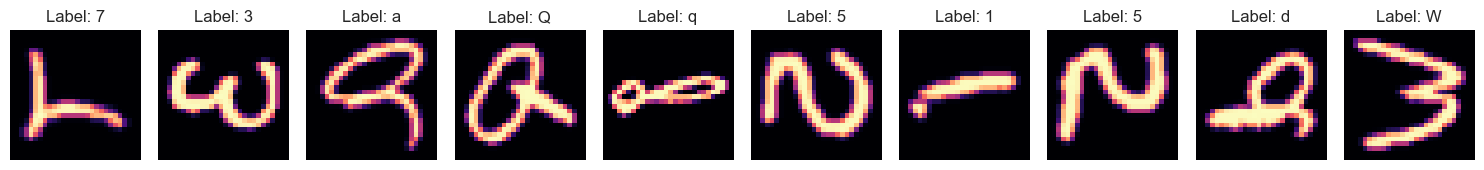

In [55]:
def plot_images(images, labels, class_mapping, num_images=10):
    """
    Plots a specified number of images along with their corresponding labels.

    Parameters:
        images (numpy.ndarray): Array of image data. Each image should be represented as a 1D array.
        labels (numpy.ndarray): Array of labels corresponding to the images.
        class_mapping (dict): A dictionary mapping label indices to their corresponding characters.
        num_images (int): Number of images to plot. Default is 10.

    Returns:
        None
    """
    # Generate random indices to select random samples
    indices = np.random.choice(len(images), num_images, replace=False)
    
    # Create subplots to plot multiple images in a single row
    _, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Iterate through the selected indices and plot each image along with its corresponding label
    for i, idx in enumerate(indices):
        ax = axes[i]
        image = images[idx].reshape(28, 28)  # Reshape image from a 1D array to a 28x28 2D array
        label_index = labels[idx]  # Get the label index for the current image
        label = chr(class_mapping[label_index])  # Convert the label index to the corresponding character using class mapping
        ax.imshow(image, cmap='magma')  # Display the image using a colormap ('magma')
        ax.set_title(f"Label: {label}")  # Set the title of the subplot to show the label
        ax.axis('off')  # Turn off axis to make the plot cleaner
    
    # Adjust the layout so that subplots do not overlap
    plt.tight_layout()
    # Display the plot
    plt.show()
    
# Call the function to plot images from the training dataset
plot_images(x_train, y_train, class_mapping)

# Function to Create a Configurable Multi-Layer Perceptron (MLP) Model

In [56]:
# Base MLP Model
def create_mlp(num_classes, optimizer='sgd', activation='relu', 
               learning_rate_scheduler=None, regularizer=None,
               use_dropout=False, use_batch_norm=False):
    """
    Creates a Multi-Layer Perceptron (MLP) model with configurable options.

    Parameters:
        num_classes (int): Number of classes in the classification task.
        optimizer (str): Name of the optimizer to use. Options: 'adam', 'sgd', 'adagrad'. Default is 'adam'.
        activation (str): Activation function to use in hidden layers. Default is 'relu'.
        learning_rate_scheduler (str): Learning rate scheduler type. Options: 'exp' (exponential), 'invdecay' (inverse decay), None (no scheduler). Default is None.
        regularizer (tensorflow.keras.regularizers.Regularizer): Regularization function. Default is None.
        use_dropout (bool): Whether to use dropout regularization. Default is False.
        use_batch_norm (bool): Whether to use batch normalization. Default is False.

    Returns:
        tensorflow.keras.models.Sequential: Compiled MLP model.
    """
    model = Sequential()  # Initialize a sequential model
    model.add(Flatten(input_shape=x_train[0].shape))  # Flatten the input to 1D array
    
    # First hidden layer
    model.add(Dense(128, kernel_regularizer=regularizer))  # Add dense layer with 128 neurons
    if use_batch_norm:  # Conditionally add batch normalization
        model.add(BatchNormalization())
    model.add(Activation(activation))  # Add activation function
    if use_dropout:  # Conditionally add dropout regularization
        model.add(Dropout(0.2))
        
    # Second hidden layer
    model.add(Dense(64, kernel_regularizer=regularizer))  # Add dense layer with 64 neurons
    if use_batch_norm:  # Conditionally add batch normalization
        model.add(BatchNormalization())
    model.add(Activation(activation))  # Add activation function
    if use_dropout:  # Conditionally add dropout regularization
        model.add(Dropout(0.2))
    
    # Third hidden layer
    model.add(Dense(64, kernel_regularizer=regularizer))  # Add dense layer with 64 neurons
    if use_batch_norm:  # Conditionally add batch normalization
        model.add(BatchNormalization())
    model.add(Activation(activation))  # Add activation function
    if use_dropout:  # Conditionally add dropout regularization
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # Add dense layer for output with softmax activation
    
    # Configure learning rate scheduler
    if learning_rate_scheduler == 'exp':
        learning_rate = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.96)
    elif learning_rate_scheduler == 'invdecay':
        learning_rate = InverseTimeDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.5)
    else:  # Default learning rate if no scheduler is used
        learning_rate = 0.01
    
    # Configure the optimizer
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    
    # Compile the model with a loss function, optimizer, and evaluation metric
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model  # Return the compiled model

# Building and Training the Multi-Layer Perceptron (MLP) Model

In [57]:
# Create an MLP model using the previously defined function 'create_mlp'
# Pass the number of unique classes in the training labels as 'num_classes' parameter
mlp_base = create_mlp(num_classes=len(np.unique(y_train)))

# Train the MLP model with training data
mlp_base_history = mlp_base.fit(
    x_train,                           # Input training images
    one_hot_y_train,                   # One-hot encoded labels for training data
    epochs=10,                         # Number of epochs to train the model
    batch_size=47,                     # Number of samples per gradient update
    validation_split=0.2,              # Fraction of the training data to use as validation data
    verbose=1                          # Verbosity mode (1 = progress bar during training)
)

Epoch 1/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 768us/step - accuracy: 0.1768 - loss: 3.3046 - val_accuracy: 0.5592 - val_loss: 1.5682
Epoch 2/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.5903 - loss: 1.4557 - val_accuracy: 0.6567 - val_loss: 1.2082
Epoch 3/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.6668 - loss: 1.1667 - val_accuracy: 0.6954 - val_loss: 1.0435
Epoch 4/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.7087 - loss: 1.0078 - val_accuracy: 0.7273 - val_loss: 0.9247
Epoch 5/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.7325 - loss: 0.9033 - val_accuracy: 0.7465 - val_loss: 0.8477
Epoch 6/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.7508 - loss: 0.8266 - val_accuracy: 0.7546 - val_loss: 0.8014
Epoch 7/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.7689 - loss: 0.7604 - val_accuracy: 0.7648 - val_loss: 0.7614
Epoch 8/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.7824 -

# Retrieve and Print Validation Accuracy and Loss of the Base MLP Model

In [58]:
# Get the final validation accuracy from the training history of the base MLP model
final_mlp_val_accuracy = mlp_base_history.history['val_accuracy'][-1]

# Get the final validation loss from the training history of the base MLP model
final_mlp_val_loss = mlp_base_history.history['val_loss'][-1]

# Print the final validation accuracy of the base MLP model
print("Accuracy of Base MLP Model:", final_mlp_val_accuracy)

# Print the final validation loss of the base MLP model
print("Loss of Base MLP Model:", final_mlp_val_loss)

Accuracy of Base MLP Model: 0.7847961187362671
Loss of Base MLP Model: 0.6784404516220093


# Hyperparameter Tuning for the MLP Model


In [59]:
# Dictionary of tunable hyperparameters and their possible values
hyperparameter_dict = {
    "activation": ['relu', 'elu', 'tanh'],  # Different activation functions to test in hidden layers
    "optimizer": ['sgd', 'adam', 'adagrad'],  # Different optimizers to test
    "learning_rate_scheduler": ["exp", "invdecay"],  # Types of learning rate schedulers to test
    'regularizer': [regularizers.l1(0.01), regularizers.l2(0.01), None],  # Regularizers to test for preventing overfitting
    "use_dropout": [True, False],  # Whether to use dropout or not
    "use_batch_norm": [True, False]  # Whether to use batch normalization or not
}

In [60]:
def optimize_hyperparameters(hyperparameter_dict, x_train, one_hot_y_train):
    """
    Optimizes hyperparameters for a given model.

    Parameters:
        hyperparameter_dict (dict): Dictionary containing hyperparameters to tune and their respective values.
        x_train (numpy.ndarray): Training data.
        one_hot_y_train (numpy.ndarray): One-hot encoded labels for training data.

    Returns:
        tuple: A tuple containing the best hyperparameters and the corresponding best accuracy.
    """
    # Start the timer to measure the optimization duration
    startTime = time.time()
    
    best_params = {}  # Dictionary to store the best hyperparameters
    best_accuracy = 0  # Variable to store the best accuracy achieved during hyperparameter tuning
    
    # Iterate through each hyperparameter in the grid
    for hyperparameter, values in hyperparameter_dict.items():
        # Iterate through each value of the current hyperparameter
        for value in values:
            # Print the current combination being tested
            print(f"Processing combination: {hyperparameter}={value}")
            val_accuracies = []  # List to store validation accuracies for the current hyperparameter setting
            
            # Create and compile the MLP model with current hyperparameters
            model = create_mlp(num_classes=len(np.unique(y_train)), **best_params)
            
            # Define EarlyStopping callback which monitors the validation loss
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            
            # Train the model and include early stopping for efficiency
            model_history = model.fit(
                x_train, one_hot_y_train, 
                epochs=10, batch_size=47, 
                validation_split=0.2, 
                verbose=2, 
                callbacks=[early_stopping]
            )

            # Evaluate the model on the validation set and calculate accuracy
            val_accuracy = model_history.history['val_accuracy'][-1]
            val_accuracies.append(val_accuracy)
            avg_val_accuracy = np.mean(val_accuracies)
            
            # Update the best hyperparameters if the current combination performs better
            if avg_val_accuracy > best_accuracy:
                best_accuracy = avg_val_accuracy
                best_params = {**best_params, hyperparameter: value}  # Update best hyperparameters
                
        # Print the best accuracy and hyperparameters for the current hyperparameter setting
        print(f"Best Accuracy of {hyperparameter}: {best_accuracy}")
        print("Best Hyperparameters:")
        for key, value in best_params.items():
            print(f"\t- {key}: {value}")

    # End the timer and compute the total training time
    endTime = time.time()
    trainingTime = endTime - startTime
    
    # Return the best hyperparameters, the best accuracy, and the total training time
    return best_params, best_accuracy, trainingTime

In [61]:
# Fine-tuning the parameters using the 'optimize_hyperparameters' function
# The function returns the best hyperparameters, the best achieved accuracy, and the total time taken for tuning
best_mlp_params, best_mlp_accuracy, time = optimize_hyperparameters(hyperparameter_dict, x_train, one_hot_y_train)

Processing combination: activation=relu
Epoch 1/10
1920/1920 - 2s - 851us/step - accuracy: 0.3070 - loss: 2.7108 - val_accuracy: 0.5466 - val_loss: 1.6354
Epoch 2/10
1920/1920 - 1s - 651us/step - accuracy: 0.6090 - loss: 1.3955 - val_accuracy: 0.6553 - val_loss: 1.2113
Epoch 3/10
1920/1920 - 1s - 677us/step - accuracy: 0.6744 - loss: 1.1357 - val_accuracy: 0.6943 - val_loss: 1.0432
Epoch 4/10
1920/1920 - 1s - 678us/step - accuracy: 0.7117 - loss: 0.9818 - val_accuracy: 0.7227 - val_loss: 0.9311
Epoch 5/10
1920/1920 - 1s - 660us/step - accuracy: 0.7394 - loss: 0.8745 - val_accuracy: 0.7437 - val_loss: 0.8460
Epoch 6/10
1920/1920 - 1s - 695us/step - accuracy: 0.7571 - loss: 0.8010 - val_accuracy: 0.7569 - val_loss: 0.7905
Epoch 7/10
1920/1920 - 1s - 660us/step - accuracy: 0.7711 - loss: 0.7460 - val_accuracy: 0.7660 - val_loss: 0.7581
Epoch 8/10
1920/1920 - 1s - 678us/step - accuracy: 0.7829 - loss: 0.7030 - val_accuracy: 0.7740 - val_loss: 0.7173
Epoch 9/10
1920/1920 - 1s - 669us/step -

The final loop will get us all the best parameters for our model apart from the predefined baseline parameters.

In [62]:
# Print the best hyperparameters found
print("Best Hyperparameters Found:")
for key, value in best_mlp_params.items():
    print(f"\t- {key}: {value}")

# Print the best validation accuracy
print(f"Best Validation Accuracy: {best_mlp_accuracy:.4f}")

# Print the total time taken for hyperparameter tuning
print(f"Total Time for Hyperparameter Tuning: {time:.2f} seconds")

Best Hyperparameters Found:
	- activation: relu
	- learning_rate_scheduler: invdecay
Best Validation Accuracy: 0.7895
Total Time for Hyperparameter Tuning: 201.90 seconds


# Training the MLP Model with Optimized Hyperparameters

In [63]:
# Create an MLP model using the best hyperparameters found during optimization
best_mlp = create_mlp(num_classes=len(np.unique(y_train)), **best_mlp_params)

# Train the MLP model with the training data using the optimized hyperparameters
best_mlp_history = best_mlp.fit(
    x_train,                           # Input training images
    one_hot_y_train,                   # One-hot encoded labels for training data
    epochs=10,                         # Number of epochs to train the model
    batch_size=47,                     # Number of samples per gradient update
    validation_split=0.2,              # Fraction of the training data to use as validation data
    verbose=1                          # Verbosity mode (1 = progress bar during training)
)

Epoch 1/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step - accuracy: 0.1576 - loss: 3.3957 - val_accuracy: 0.5390 - val_loss: 1.6620
Epoch 2/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.5750 - loss: 1.5224 - val_accuracy: 0.6392 - val_loss: 1.2571
Epoch 3/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.6499 - loss: 1.2255 - val_accuracy: 0.6797 - val_loss: 1.0959
Epoch 4/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.6915 - loss: 1.0566 - val_accuracy: 0.7034 - val_loss: 0.9814
Epoch 5/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.7179 - loss: 0.9658 - val_accuracy: 0.7228 - val_loss: 0.9119
Epoch 6/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.7349 - loss: 0.8909 - val_accuracy: 0.7329 - val_loss: 0.8745
Epoch 7/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.7515 - loss: 0.8391 - val_accuracy: 0.7496 - val_loss: 0.8170
Epoch 8/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.7615 -

# Saving the Trained MLP Model

In [64]:
# Save the trained MLP model to a file named 'mlp_model.h5'
# The 'overwrite=True' parameter ensures that any existing file with the same name will be overwritten
best_mlp.save("mlp_model.h5", overwrite=True)

# Plotting Training and Validation Loss and Accuracy

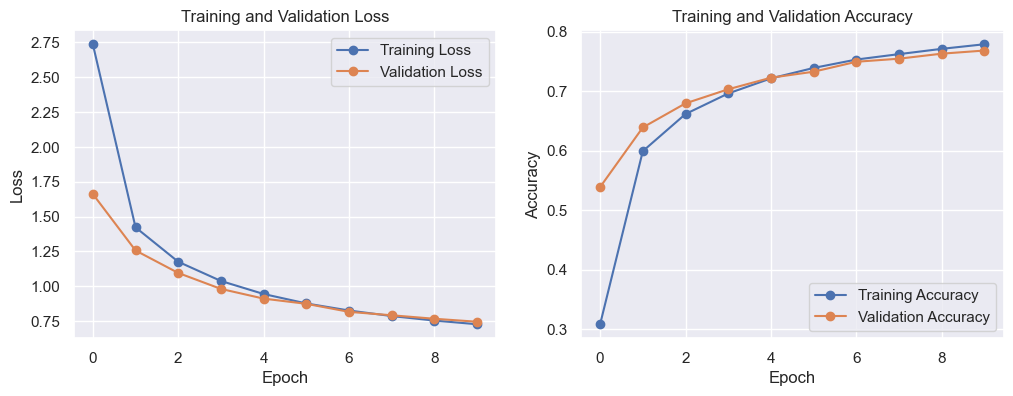

In [65]:
def plot_loss_and_accuracy(model_history):
    """
    Plots the training and validation loss, as well as training and validation accuracy, from a given model's training history.

    Parameters:
        model_history (History): History object returned by the `fit` method of a Keras model, containing training metrics.

    Returns:
        None
    """
    # Create a figure with a specified size for better readability
    plt.figure(figsize=(12, 4))

    # Plot the training and validation loss on the left subplot
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], '-o', label='Training Loss')  # Plot training loss
    plt.plot(model_history.history['val_loss'], '-o', label='Validation Loss')  # Plot validation loss
    plt.title('Training and Validation Loss')  # Title for the loss plot
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.legend()  # Display a legend to differentiate between training and validation loss
    
    # Plot the training and validation accuracy on the right subplot
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], '-o', label='Training Accuracy')  # Plot training accuracy
    plt.plot(model_history.history['val_accuracy'], '-o', label='Validation Accuracy')  # Plot validation accuracy
    plt.title('Training and Validation Accuracy')  # Title for the accuracy plot
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.legend()  # Display a legend to differentiate between training and validation accuracy

    # Show the plots
    plt.show()

# Call the function to plot the loss and accuracy for the best MLP model's training history
plot_loss_and_accuracy(best_mlp_history)

# Results
### Loading the Trained MLP Model

In [66]:
# Load the trained MLP model from the saved file 'mlp_model.h5'
best_mlp = load_model('mlp_model.h5')

### Evaluating the Trained MLP Model on Test Data

In [67]:
# Evaluate the trained MLP model on the test dataset
# 'evaluate' method returns the loss and accuracy on the test data
mlp_result = best_mlp.evaluate(x_test, one_hot_y_test)

# Print the test loss and test accuracy
print(f"Test Loss: {mlp_result[0]}")
print(f"Test Accuracy: {mlp_result[1]}")

588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.7723 - loss: 0.7635
Test Loss: 0.7689430117607117
Test Accuracy: 0.769361674785614


### Making Predictions with the Trained MLP Model

In [68]:
# Use the trained MLP model to make predictions on the test dataset
# 'predict' method returns the predicted probabilities for each class
mlp_pred = best_mlp.predict(x_test, verbose=1)

# Print the shape of the prediction array to verify the output
print(f"Shape of prediction array: {mlp_pred.shape}")

# Optional: Show a few sample predictions and their corresponding true labels
for i in range(5):
    print(f"Sample {i + 1}:")
    print(f"Predicted probabilities: {mlp_pred[i]}")
    print(f"Predicted class: {np.argmax(mlp_pred[i])}")
    print(f"True class: {np.argmax(one_hot_y_test[i])}\n")

588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
Shape of prediction array: (18800, 47)
Sample 1:
Predicted probabilities: [4.2911419e-03 3.1365514e-06 6.0616825e-05 8.8959984e-02 2.2337357e-05
 6.6751678e-04 3.0914855e-08 2.2469871e-03 2.8939028e-03 1.2410195e-02
 1.0756636e-05 4.9197616e-04 1.0013545e-04 2.1706581e-04 1.9426502e-06
 6.1357655e-06 2.0744916e-05 5.8635749e-07 4.2139945e-06 3.7368972e-04
 4.9825271e-08 1.3714377e-07 1.2800547e-06 2.0008285e-07 1.9878761e-03
 1.4833678e-04 8.3171311e-05 9.9632587e-07 6.9243030e-04 1.5193922e-06
 1.1795997e-05 2.2732784e-05 2.9404729e-08 1.3358084e-06 7.4434648e-03
 4.1727380e-05 3.4448475e-04 7.8736230e-07 1.3028098e-05 3.7407037e-05
 1.0753066e-05 8.5637003e-01 1.3158427e-10 4.1744001e-06 1.7688762e-02
 3.0146651e-07 2.3100502e-03]
Predicted class: 41
True class: 41

Sample 2:
Predicted probabilities: [5.2787364e-04 6.3949290e-11 8.2645363e-10 2.3767037e-09 9.4882817e-11
 6.8139634e-08 1.0052095e-11 7.0219025e-11 5.2530115e-05 2.6289931e-07
 

## Predicted Results
### Plotting Test Images with True and Predicted Labels

In [85]:
def pred_images(x_test, y_test, predicted_labels, class_mapping, num_images=5):
    """
    Plots a specified number of images from the test set along with their true and predicted labels.

    Parameters:
        x_test (numpy.ndarray): Array of test images.
        y_test (numpy.ndarray): Array of true labels corresponding to the test images.
        predicted_labels (numpy.ndarray): Array of predicted labels for the test images.
        class_mapping (dict): A dictionary mapping label indices to their corresponding characters.
        model (str): Name or identifier of the model used for predictions, displayed as the title of the plot.
        num_images (int): Number of images to plot. Default is 6.

    Returns:
        None
    """
    # Generate indices for first specified number of samples
    indices = list(range(0, num_images))
    
    # Create subplots for displaying images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    # Plot each image with its true and predicted labels
    for i, idx in enumerate(indices):
        ax = axes[i]
        image = x_test[idx].reshape(28, 28)  # Reshape image from a 1D array to a 28x28 2D array
        true_label_index = y_test[idx]  # Get the true label index for the current image
        true_label = class_mapping[true_label_index]  # Get the true label character using class mapping
        predicted_label_index = predicted_labels[idx]  # Get the predicted label index for the current image
        predicted_label = class_mapping[predicted_label_index]  # Get the predicted label character using class mapping 
        ax.imshow(image, cmap='magma')  # Display the image using the 'magma' colormap
        # Set the title for each subplot to show true and predicted labels
        # ax.set_title(f"True Label: {chr(true_label)} ({true_label})\nPredicted Label: {chr(predicted_label)} ({predicted_label})")
        ax.set_title(f"True Label: {chr(true_label)}\nPredicted Label: {chr(predicted_label)}")
        ax.axis('off')  # Turn off axis for better visual representation

    # Adjust layout to prevent overlap and show the plot
    plt.tight_layout()
    plt.show()


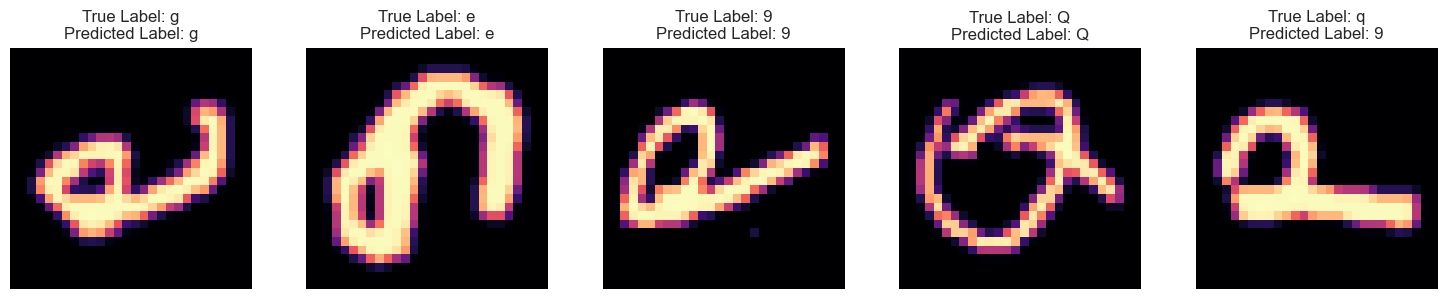

In [86]:

# Convert one-hot encoded predictions to class labels
mlp_pred_indices = np.argmax(mlp_pred, axis=1)

# Plot images with their true labels and the predicted labels from the MLP model
pred_images(x_test, y_test, mlp_pred_indices, class_mapping)

## Summary of the results
We now calcuate the final perfomance metrics of the two models

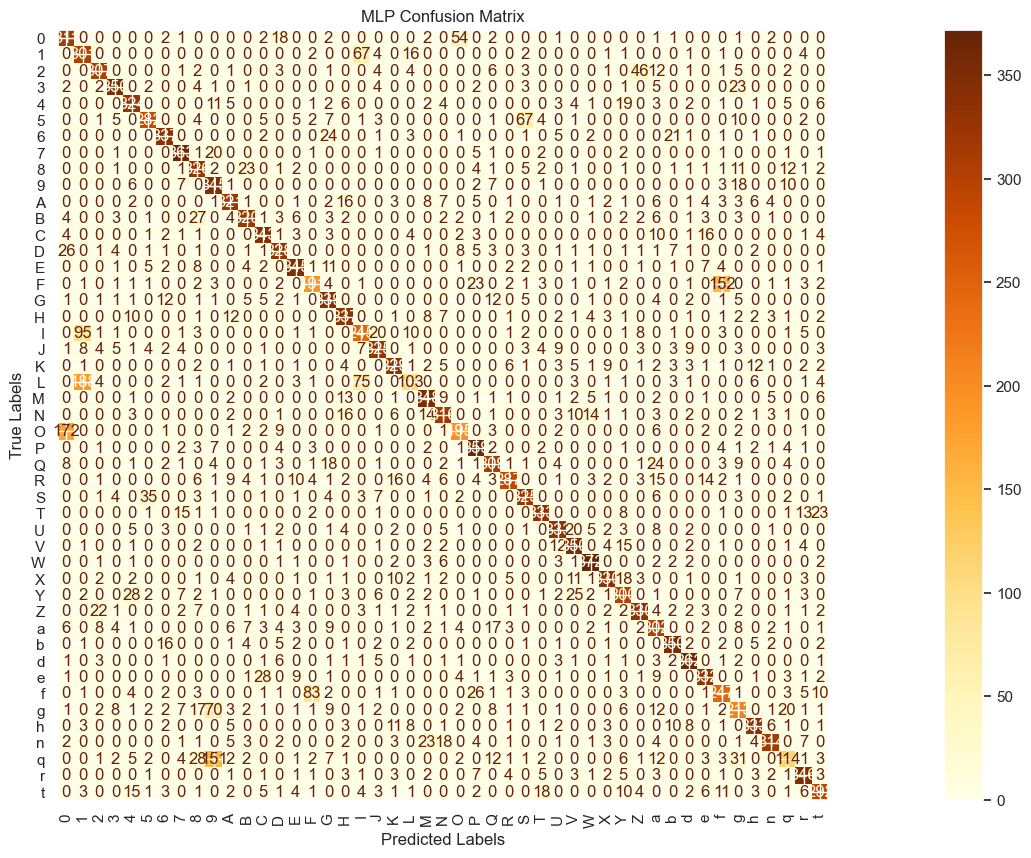

In [71]:
### Plotting the Confusion Matrix for Model Predictions

def plot_confusion_matrix(y_test, y_pred, title, class_mapping):
    """
    Plots a confusion matrix using ConfusionMatrixDisplay.

    Parameters:
        y_test (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        title (str): Title of the plot.
        class_mapping (dict): A dictionary mapping label indices to their corresponding characters.

    Returns:
        None
    """
    # Calculate the confusion matrix based on true and predicted labels
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a ConfusionMatrixDisplay object for displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping.values())
    
    # Set the figure size for better readability
    plt.figure(figsize=(30, 10))
    
    # Plot the confusion matrix with a color map and add it to the current Axes
    disp.plot(cmap='YlOrBr', ax=plt.gca())
    
    # Set the title, x-axis label, and y-axis label of the plot
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    # Convert numeric indices to ASCII characters for x-ticks and y-ticks
    xtick_labels = [chr(class_mapping[i]) for i in range(len(class_mapping))]
    ytick_labels = [chr(class_mapping[i]) for i in range(len(class_mapping))]
    
    # Set the ticks and labels on the x-axis and y-axis with a rotation for the x-ticks
    plt.xticks(ticks=range(len(class_mapping)), labels=xtick_labels, rotation=90)
    plt.yticks(ticks=range(len(class_mapping)), labels=ytick_labels)
    
    # Display the plot
    plt.show()

# Plot the confusion matrix for the MLP model's predictions with class labels
plot_confusion_matrix(y_test, mlp_pred_indices, title='MLP Confusion Matrix', class_mapping=class_mapping)

We calculate accuracy, precision, recall and f1-score

In [77]:
def calculate_metrics(model_name, y_test, y_pred):
    """
    Calculates evaluation metrics (accuracy, precision, recall, F1 score) for a given model's predictions.

    Parameters:
        model_name (str): Name or identifier of the model.
        y_test (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    # Calculate accuracy, precision, recall and f-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Return metrics as a dictionary
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Calculate metrics for MLP model
mlp_metrics = calculate_metrics('MLP', y_test, mlp_pred_indices)
# Create a DataFrame to store the metric
metrics_df = pd.DataFrame([mlp_metrics])
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,MLP,0.769362,0.77381,0.769362,0.765462
